# 🌡️ Previsão de Temperatura em Cidades Brasileiras

Este notebook apresenta um pipeline completo de modelagem preditiva aplicado a séries temporais de temperatura mensal em cidades brasileiras.

## 🎯 Objetivo
Comparar o desempenho de diferentes modelos de aprendizado supervisionado — incluindo regressão clássica e modelos de boosting — na tarefa de prever temperaturas mensais com base em atributos temporais derivados.

## 📂 Dados
Os dados históricos consistem em séries de temperatura média mensal por cidade, com colunas de mês e ano. O pré-processamento inclui:
- Conversão do formato wide → long
- Tratamento de outliers (> 70 °C)
- Conversão para datetime
- Engenharia de atributos (lags, médias móveis, seno/cosseno de mês)

## 🤖 Modelos Avaliados
- **Regressão Clássica**: Random Forest, Ridge, Extra Trees, HistGradientBoosting
- **Boosting**: XGBoost, LightGBM

Todos os modelos são avaliados usando múltiplas divisões de treino/teste (`train_size`) e múltiplas sementes aleatórias, garantindo robustez estatística.

## 📊 Avaliação
As métricas analisadas são:
- MAE (Erro Absoluto Médio)
- RMSE (Raiz do Erro Quadrático Médio)
- R² (Coeficiente de Determinação)

As distribuições dessas métricas são visualizadas para cada modelo, permitindo análise comparativa de desempenho.

---


# Carregamento de Dados 

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path
sys.path.append(os.path.abspath(".."))

In [21]:
import pandas as pd
from data_loader import load_city_temperature

# Caminho do arquivo
file_path = "/workspaces/gabrielcp-portfolio/brazilian-temperature-forecast/data/station_sao_paulo.csv"  # substitua pelo seu CSV real
city_name = "São Paulo"

# Carregamento e limpeza
df = load_city_temperature(file_path)
#df.head()


# Criação de Atributos 

In [22]:
import importlib as il
import feature_engineering as f_e
il.reload(f_e)

<module 'feature_engineering' from '/workspaces/gabrielcp-portfolio/brazilian-temperature-forecast/feature_engineering.py'>

In [23]:
df_feat = f_e.create_time_features(df)

In [25]:
# Features selecionadas
features = ['Month', 'Year', 'sin_month', 'cos_month', 'lag_1', 'lag_12', 'rolling_mean_3', 'rolling_std_3']
target = 'Temperature'

X = df_feat[features].values
y = df_feat[target].values


# Visualização Exploratória 

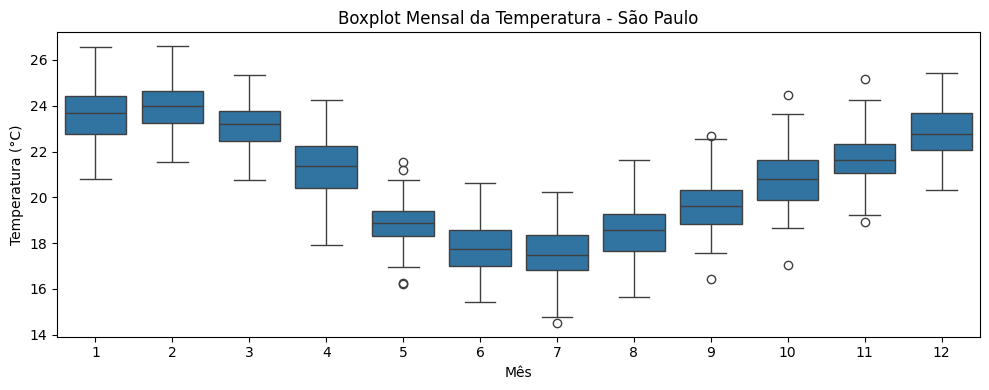

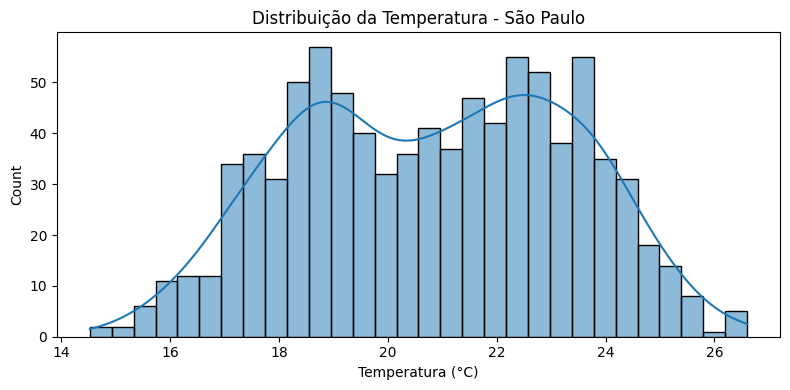

In [24]:
from plotting import plot_eda_summary
plot_eda_summary(df, "São Paulo")

# Treinando Modelos e Avaliando com Amostragem 

🤖 Modelos de Regressão Utilizados

Neste projeto, foram utilizados quatro modelos de regressão supervisionada, cada um com características distintas em termos de complexidade, capacidade de generalização e sensibilidade a ruídos:

🔹 Random Forest Regressor

Modelo baseado em um conjunto de árvores de decisão treinadas sobre diferentes subconjuntos dos dados. Utiliza o princípio de bagging (bootstrap aggregation) para reduzir variância e melhorar a estabilidade da previsão. É robusto a outliers e captura bem relações não lineares.

🔹 Extra Trees Regressor

Semelhante ao Random Forest, porém mais aleatorizado: além de subamostrar os dados, também escolhe os pontos de divisão de forma aleatória. Isso reduz o viés e torna o modelo ainda mais rápido, com desempenho comparável em muitos casos.

🔹 HistGradientBoosting Regressor

Implementação eficiente de boosting baseada em histogramas, especialmente indicada para grandes volumes de dados. Funciona bem com dados contínuos e categóricos, e tende a superar Random Forest quando bem parametrizado.

🔹 Ridge Regression

Modelo de regressão linear com regularização L2. Penaliza coeficientes altos para reduzir overfitting e melhorar a generalização. É útil como baseline interpretável, e por funcionar bem quando há multicolinearidade entre atributos.

In [26]:
from models.regression_models import get_regression_models
from evaluation.sampling import run_sampling

# Modelos clássicos
models = get_regression_models()

# Avaliação repetida
df_results = run_sampling(df_feat, models=models, features=features, target=target, n_runs=20)
df_results.head()

,Model,Train_Size,Seed,MAE,RMSE,R2
0,Random Forest,0.55,1265,0.579224,0.744594,0.914588
1,HistGradientBoosting,0.55,1265,0.479411,0.648321,0.935247
2,Extra Trees,0.55,1265,0.518152,0.676106,0.929578
3,Ridge Regression,0.55,1265,0.618447,0.777143,0.906957
4,Random Forest,0.55,1771,0.579224,0.744594,0.914588


In [36]:
metrica='R2'
# Seleciona as top 3 execuções de cada modelo com menor MAE
top_instances = (
    df_results
    .sort_values(metrica, ascending=False) # ascending=False caso seja o R² 
    .groupby("Model", group_keys=False)
    .head(3)
    .reset_index(drop=True)
)

print(f"🎯 Top 3 execuções por modelo com menor {metrica}:")
display(top_instances)


🎯 Top 3 execuções por modelo com menor R2:


,Model,Train_Size,Seed,MAE,RMSE,R2
0,HistGradientBoosting,0.83,9816,0.408429,0.544426,0.950786
1,HistGradientBoosting,0.83,133,0.408429,0.544426,0.950786
2,HistGradientBoosting,0.83,2349,0.408429,0.544426,0.950786
3,Random Forest,0.83,8699,0.460141,0.581641,0.943828
4,Random Forest,0.83,2349,0.460141,0.581641,0.943828
5,Random Forest,0.83,2629,0.460141,0.581641,0.943828
6,Extra Trees,0.83,1771,0.450894,0.583099,0.943546
7,Extra Trees,0.83,2240,0.450894,0.583099,0.943546
8,Extra Trees,0.83,1302,0.450894,0.583099,0.943546
9,Ridge Regression,0.90,1310,0.598226,0.739115,0.911975


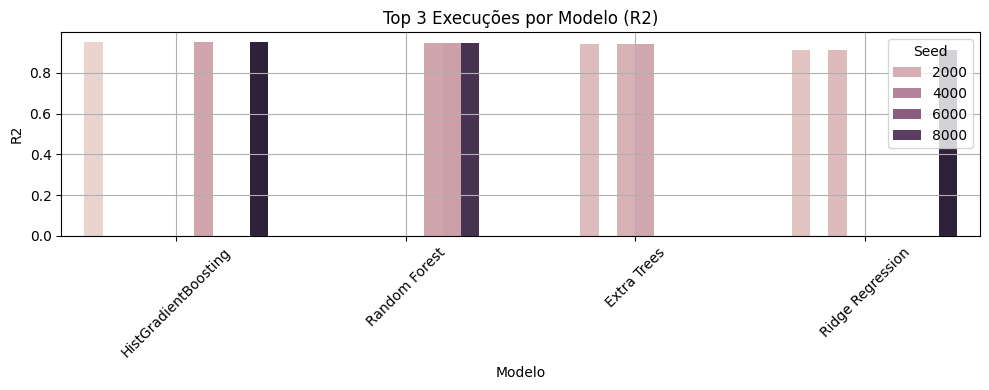

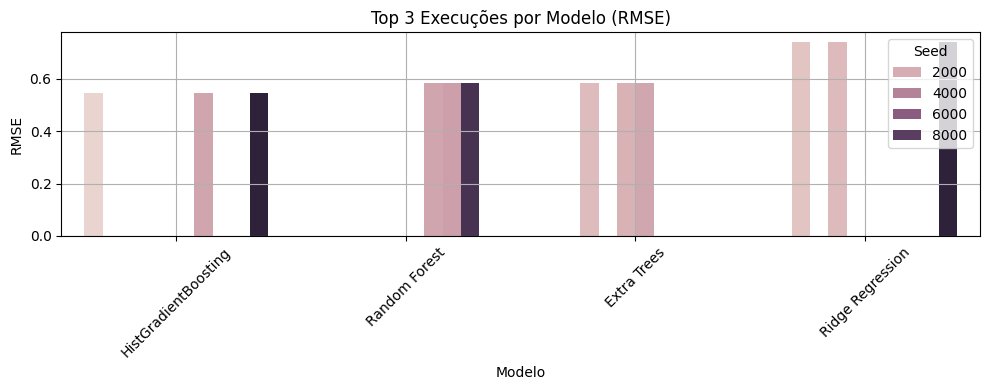

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico para a métrica principal selecionada
plt.figure(figsize=(10, 4))
sns.barplot(data=top_instances, x="Model", y=metrica, hue="Seed")
plt.title(f"Top 3 Execuções por Modelo ({metrica})")
plt.xlabel("Modelo")
plt.ylabel(metrica)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Gráfico complementar para RMSE (fixo, se quiser manter como referência cruzada)
if metrica != "RMSE":
    plt.figure(figsize=(10, 4))
    sns.barplot(data=top_instances, x="Model", y="RMSE", hue="Seed")
    plt.title("Top 3 Execuções por Modelo (RMSE)")
    plt.xlabel("Modelo")
    plt.ylabel("RMSE")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


# Previsão com Prophet 

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
13:58:36 - cmdstanpy - INFO - Chain [1] start processing
13:58:36 - cmdstanpy - INFO - Chain [1] done processing



📍 Modelo: Prophet
MAE:  0.83
RMSE: 1.02
R²:   0.827


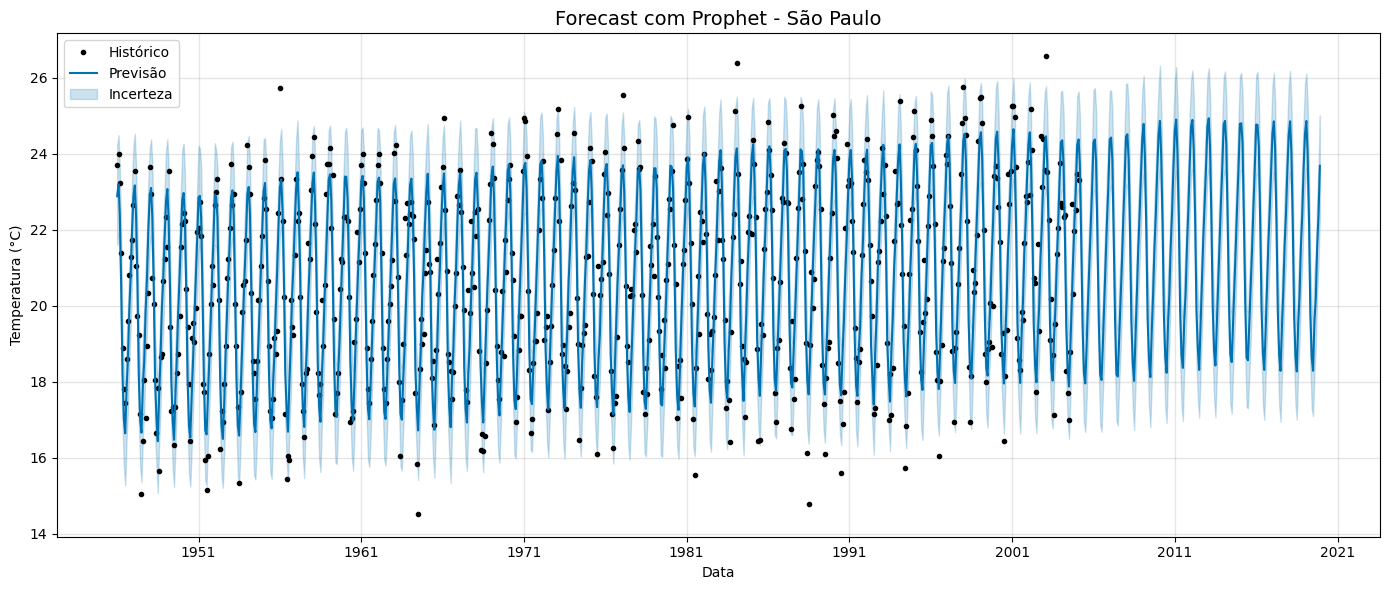

,ds,yhat,yhat_lower,yhat_upper
883,2019-08-01,19.574420,18.229846,20.916512
884,2019-09-01,20.209617,18.955602,21.426580
885,2019-10-01,21.532636,20.266811,22.784115
886,2019-11-01,22.390840,21.098860,23.677660
887,2019-12-01,23.683397,22.382373,25.011389


In [42]:
from models.prophet_model import train_prophet_model

# Treinamento e previsão com Prophet
forecast = train_prophet_model(df, city_name=city_name)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# Previsão com ARIMA e Sarima 

⏳ Modelos de Séries Temporais Clássicos
Modelos estatísticos de séries temporais são especialmente desenhados para lidar com dados ordenados no tempo, capturando padrões como tendência, sazonalidade e autocorrelação.

🔹 ARIMA (AutoRegressive Integrated Moving Average)

O modelo ARIMA combina três componentes:

AR (AutoRegressivo): prevê o valor atual com base em valores passados.

I (Integrated): representa a diferença entre os valores, para tornar a série estacionária.

MA (Média Móvel): modela o erro como uma combinação linear de erros passados.

ARIMA é eficaz para séries estacionárias ou que podem ser estabilizadas por diferenciação.

🔹 SARIMA (Seasonal ARIMA)

Extensão do ARIMA que incorpora sazonalidade explícita, por meio de parâmetros adicionais que capturam padrões cíclicos regulares (mensais, trimestrais, etc.). Muito útil para séries com sazonalidade pronunciada, como dados climáticos mensais.

🔹 Prophet

Modelo desenvolvido pelo Facebook, pensado para usuários não especialistas em séries temporais. Baseia-se em decomposição aditiva:

Tendência (piecewise linear ou logística)

Sazonalidade (via funções harmônicas)

Feriados/eventos externos (opcional)

O Prophet é robusto a outliers, perda de dados e mudanças estruturais, além de permitir fácil interpretação e customização.

Esses modelos foram aplicados diretamente sobre a série de temperatura, com divisão temporal tradicional entre treino e teste. Cada um deles oferece vantagens específicas em termos de interpretabilidade, robustez e capacidade de capturar padrões sazonais.

In [43]:
from models.arima_models import train_arima, train_sarima

# ARIMA padrão
y_true_arima, y_pred_arima = train_arima(df)

# SARIMA com sazonalidade mensal
y_true_sarima, y_pred_sarima = train_sarima(df)



📍 Modelo: ARIMA
MAE:  2.45
RMSE: 3.03
R²:   -0.539

📍 Modelo: SARIMA
MAE:  0.81
RMSE: 0.99
R²:   0.836


# Previsão com LSTM

🔁 Modelo de Rede Neural Recorrente – LSTM

Redes neurais recorrentes (RNNs) são especialmente projetadas para lidar com dados sequenciais. No contexto de séries temporais, elas conseguem aprender padrões temporais complexos, levando em conta a ordem dos dados ao longo do tempo.

🔸 LSTM (Long Short-Term Memory)

O LSTM é uma arquitetura de RNN que resolve o problema do “desvanecimento do gradiente”, permitindo que o modelo aprenda dependências de longo prazo. Ele utiliza mecanismos chamados de portas (gate structures) para decidir o que manter, esquecer ou atualizar em sua “memória” interna.

No projeto, o LSTM foi configurado com:

Uma camada LSTM com 64 unidades

Uma camada densa de saída

Função de ativação tanh e otimizador adam

EarlyStopping para evitar overfitting

Os dados foram normalizados com MinMaxScaler, e a rede foi treinada com janelas deslizantes de tamanho fixo (n_steps=12) para capturar contextos mensais.

Embora seja mais custoso computacionalmente, o LSTM é capaz de modelar relações temporais não lineares de forma muito expressiva, sendo especialmente interessante quando padrões complexos não são capturados adequadamente por modelos tradicionais.

2025-05-08 14:00:14.378741: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 14:00:14.659824: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 14:00:14.792545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746712815.085411   10091 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746712815.178594   10091 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746712815.792970   10091 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

📍 Modelo: LSTM
MAE:  0.90
RMSE: 1.13
R²:   0.786


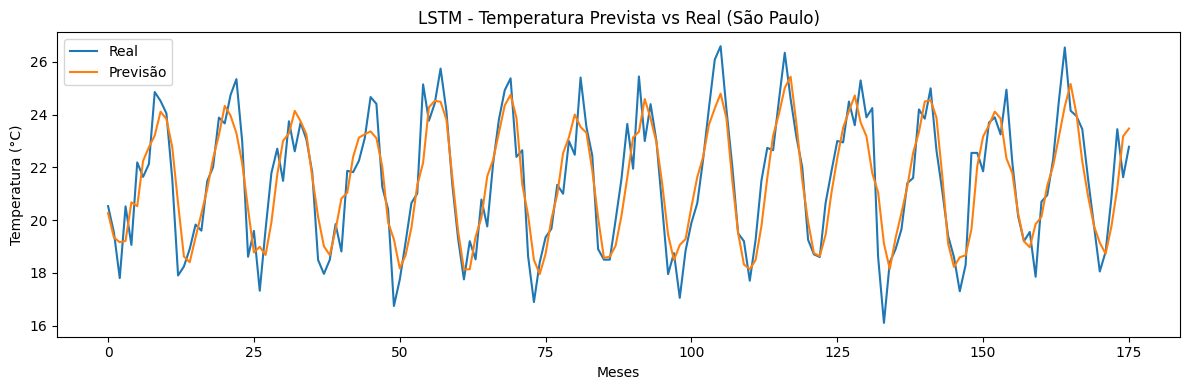

In [44]:
from models.lstm_model import train_lstm_model

# Treinamento com LSTM
model_lstm = train_lstm_model(df, city_name=city_name)


# Previsão com XGBoost e LightGBM

⚡ Modelos de Boosting Utilizados

Boosting é uma técnica de ensemble que combina diversos modelos fracos (geralmente árvores de decisão) em uma sequência adaptativa. A cada iteração, o modelo tenta corrigir os erros cometidos pelos anteriores, resultando em previsores altamente performáticos.

🔸 XGBoost (Extreme Gradient Boosting)

Um dos algoritmos mais populares em competições de machine learning, o XGBoost implementa uma versão otimizada do Gradient Boosting com regularização, paralelismo e manejo eficiente de valores ausentes. É altamente configurável e oferece excelente desempenho tanto em velocidade quanto em acurácia.

🔸 LightGBM (Light Gradient Boosting Machine)

Desenvolvido pela Microsoft, o LightGBM é uma alternativa ainda mais rápida e escalável que o XGBoost, especialmente em datasets grandes. Utiliza histogramas para acelerar a construção das árvores e uma estratégia chamada leaf-wise tree growth, que aprofunda seletivamente as ramificações com maior ganho de informação.

Ambos os modelos foram avaliados no pipeline com variação de tamanho de treino e múltiplas sementes aleatórias, fornecendo uma base sólida para comparação estatística com os demais algoritmos de regressão.


📍 Modelo: XGBoost
MAE:  0.43
RMSE: 0.55
R²:   0.949


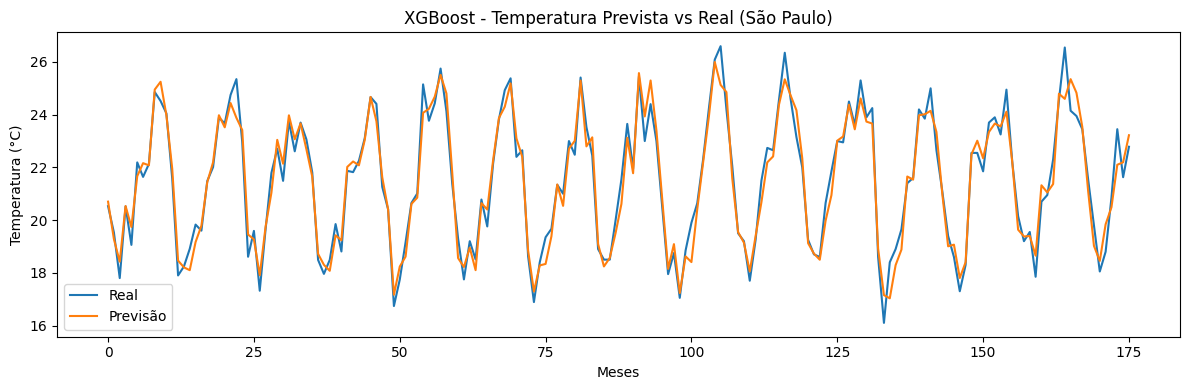


📍 Modelo: LightGBM
MAE:  0.41
RMSE: 0.54
R²:   0.951


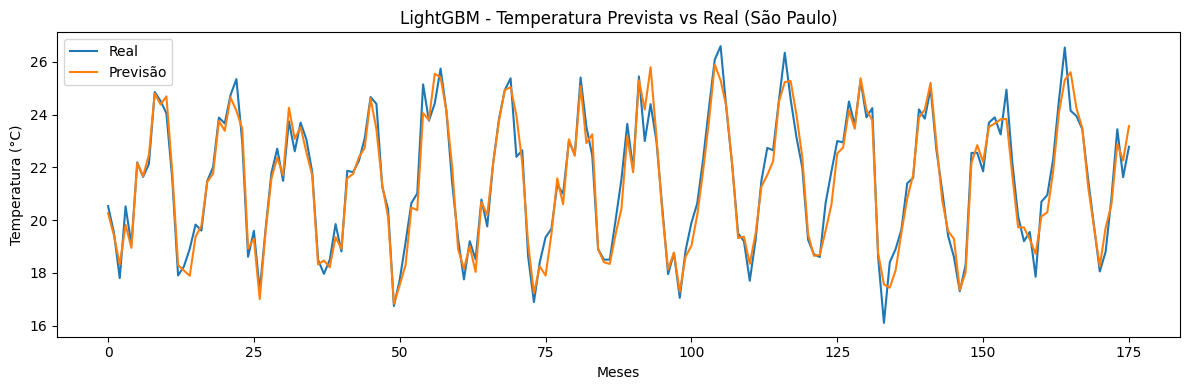

In [46]:
from models.boosting_models import train_boosting_models

# Divisão tradicional
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Treinamento com boosting
train_boosting_models(X_train, X_test, y_train, y_test, city_name=city_name)


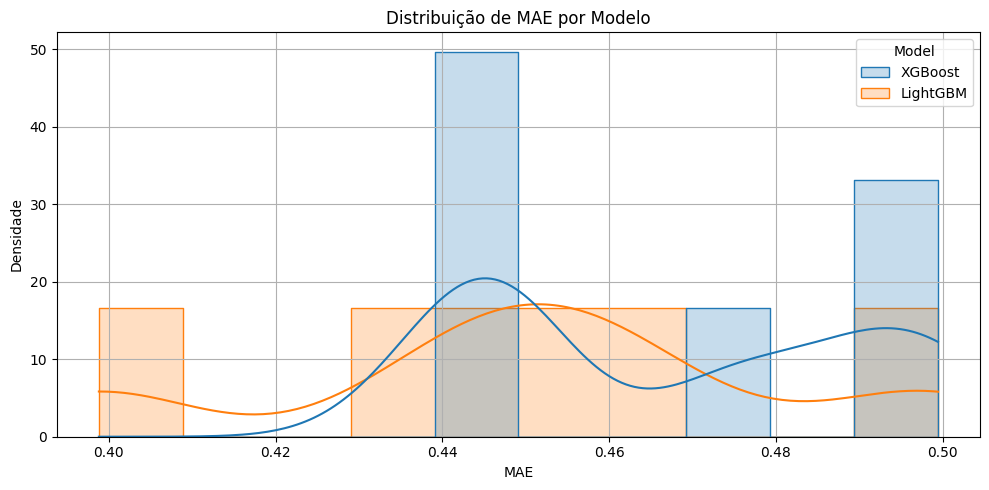

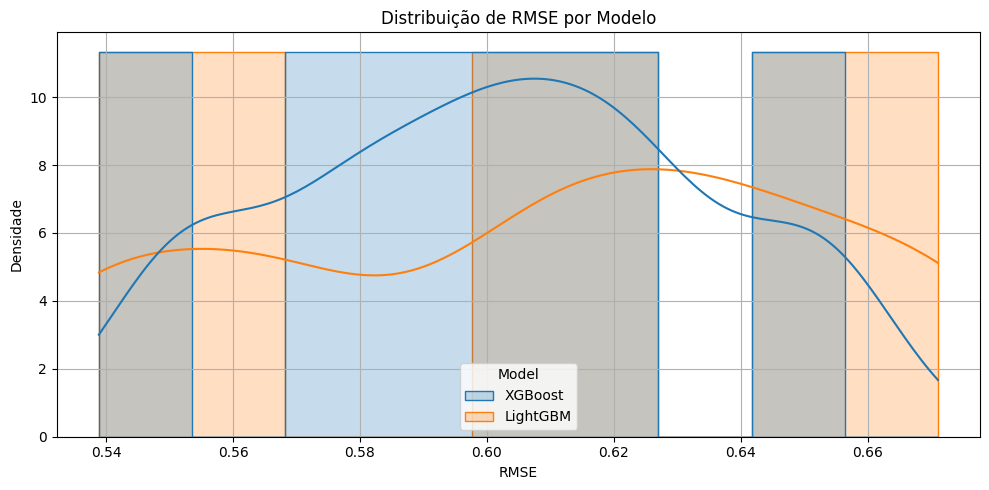

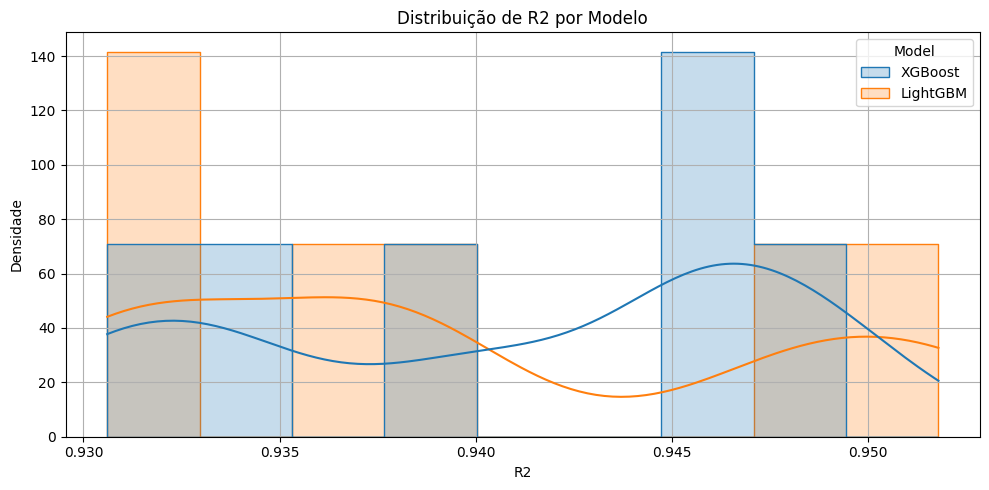

In [49]:
import models.boosting_models as BMs 
il.reload(BMs)

from evaluation.sampling import run_sampling
from evaluation.plot_distributions import plot_distribution_all

# Modelos Boosting com a mesma API
models_boosting = BMs.get_boosting_models()

# Avaliação repetida com sampling
df_boosting_results = run_sampling(df_feat, models=models_boosting, features=features, target=target, n_runs=20)

# Visualização
plot_distribution_all(df_boosting_results)


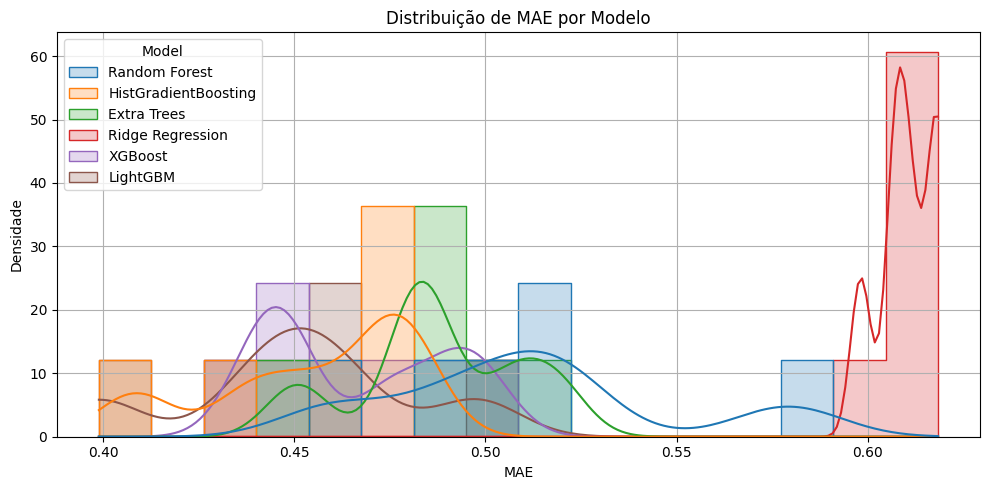

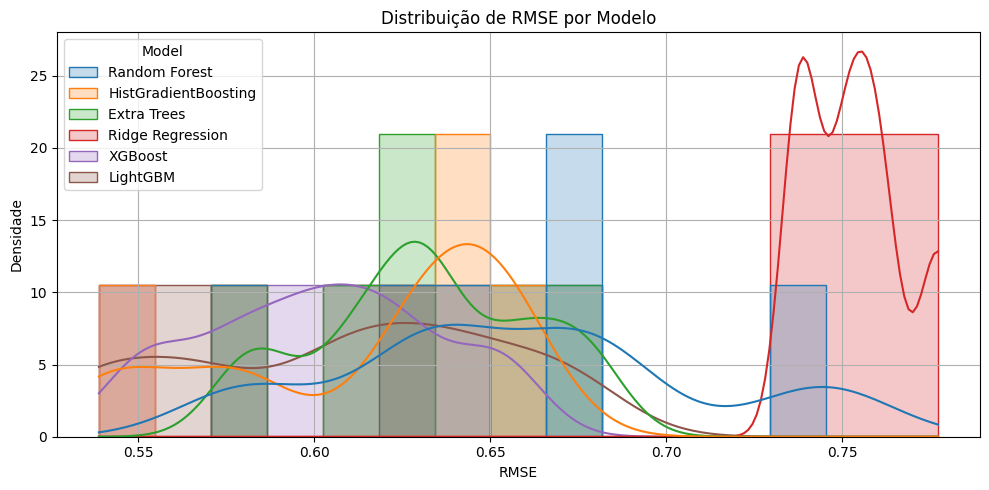

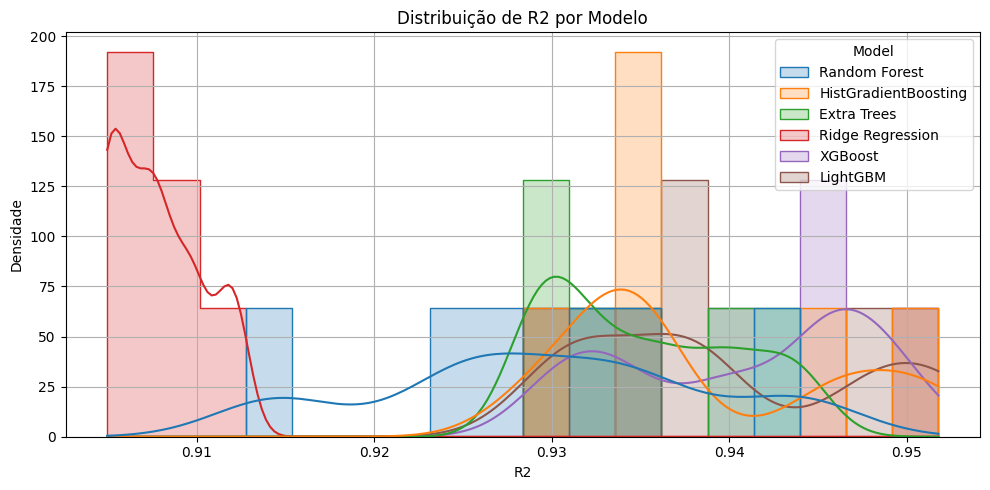

In [50]:
import pandas as pd
from evaluation.plot_distributions import plot_distribution_all

# Combina os resultados
df_all = pd.concat([df_results, df_boosting_results], ignore_index=True)

# Visualização conjunta
plot_distribution_all(df_all)


# Conclusão

🔍 Principais observações:

Modelos como XGBoost e LightGBM ofereceram excelente desempenho em termos de erro e estabilidade.

Modelos estatísticos (ARIMA/SARIMA/Prophet) se mostraram interpretáveis e eficazes para séries com padrões sazonais claros.

LSTM foi útil para capturar padrões não lineares, embora com maior custo computacional.

A engenharia de atributos temporais (lags, sazonais, médias móveis) foi essencial para melhorar a performance dos modelos baseados em aprendizado de máquina.

Este estudo pode ser expandido para previsão de outras variáveis climáticas, aplicação em diferentes cidades, ou integração com fontes externas (ex: altitude, precipitação).